# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [88]:
# Set the theme here
THEME = 'eu_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [89]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [90]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [91]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 20 # This was lowered from 50 to 10 for gender_HU
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [92]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,u2017-11-15-13,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Józsa, István",M,1953.0,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt...",Tisztelt Képviselőtársaim! Szeretnék csatlako...,0.694824,3762
1,u2017-11-15-27,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,JOBBIK-frakció,A Jobbik Magyarországért Mozgalom parlamenti f...,Opposition,"Ander, Balázs",M,1976.0,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt...",Tisztelt Képviselőtársaim! Tisztelt Államtitk...,-0.725098,12772
2,u2017-11-15-37,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Fónagy, János",M,1942.0,"Köszönöm, elnök úr. Tisztelt Ház! Tisztelt Kép...",Tisztelt Ház! Tisztelt Képviselőtársaim! A tö...,0.320312,7822
3,u2017-11-15-41,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Heringes, Anita",F,1984.0,Nagyon szépen köszönöm a szót. Tisztelt Ház! A...,Tisztelt Ház! A javaslat célja az idegenforga...,-0.380615,3071
4,u2017-11-15-51,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-15,Unicameralism,7,NaN,88,3,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Józsa, István",M,1953.0,"Köszönöm szépen, elnök úr, a lehetőséget. Ez e...","Ez egy olyan napirend, ami pontosan mutatja, ...",0.234009,6052


In [93]:
df['Speaker_party'].describe()

count               6594
unique                19
top       Fidesz-frakció
freq                2667
Name: Speaker_party, dtype: object

In [94]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [95]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.1)


In [96]:
pd.Series(new_topics).value_counts()

-1     1324
 0     1226
 1      177
 2      170
 5      153
       ... 
 79      25
 69      24
 66      24
 68      23
 78      20
Length: 81, dtype: int64

In [97]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [98]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [99]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 81
Number of topics before: 81


In [100]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     2224
 22    1058
 17     152
 30     136
 57     116
       ... 
 76      22
 2       22
 12      22
 59      20
 47      20
Length: 81, dtype: int64

In [101]:
topic_model.visualize_topics()

Topics over time

In [102]:
# Reference running time for this cell: 2min 30s

# topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [103]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [104]:
# topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [105]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

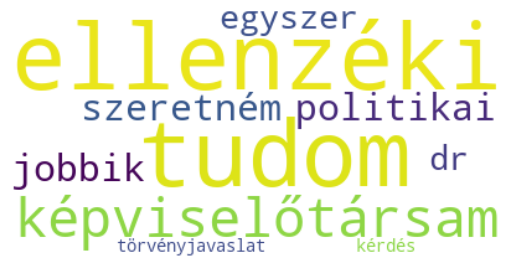

In [106]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [107]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [108]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['ellenzéki',
 'tudom',
 'képviselőtársam',
 'politikai',
 'szeretném',
 'jobbik',
 'egyszer',
 'dr',
 'törvényjavaslat',
 'kérdés']

In [109]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
speech_topic_party.loc[speech_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
speech_topic_party.loc[speech_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,528.0,486.0,198.0
1,94.0,43.0,40.0
2,88.0,64.0,17.0
3,87.0,35.0,20.0
4,91.0,23.0,5.0
5,72.0,45.0,32.0
6,145.0,0.0,2.0
7,68.0,32.0,4.0
8,35.0,41.0,31.0


In [110]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,42.1,61.1,53.5
1,7.5,5.4,10.8
2,7.0,8.1,4.6
3,6.9,4.4,5.4
4,7.3,2.9,1.4
5,5.7,5.7,8.6
6,11.6,0.0,0.5
7,5.4,4.0,1.1
8,2.8,5.2,8.4


In [111]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-KDNP,OTHER,Opposition,keywords
topic,,,,
0,42.1,61.1,53.5,"[ellenzéki, tudom, képviselőtársam, politikai,..."
1,7.5,5.4,10.8,"[köztársaság, horvátország, megállapodáshoz, k..."
2,7.0,8.1,4.6,"[illegális, kvótarendszer, migránsok, kötelező..."
3,6.9,4.4,5.4,"[megújulóenergia, villamos, rezsicsökkentés, l..."
4,7.3,2.9,1.4,"[koronavírus, vakcinát, oltási, baloldal, 2021..."
5,5.7,5.7,8.6,"[költségvetést, növekedés, milliárd, infláció,..."
6,11.6,0.0,0.5,"[módosító, tartózkodás, jelentést, 46, házszab..."
7,5.4,4.0,1.1,"[ttip, királyság, miniszterelnök, kilépés, mag..."
8,2.8,5.2,8.4,"[minimálbér, nők, férfiak, szegénységben, szak..."


In [112]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-KDNP,OTHER,Opposition
0,0,43.6,40.1,16.3
1,1,53.1,24.3,22.6
2,2,52.1,37.9,10.1
3,3,61.3,24.6,14.1
4,4,76.5,19.3,4.2
5,5,48.3,30.2,21.5
6,6,98.6,0.0,1.4
7,7,65.4,30.8,3.8
8,8,32.7,38.3,29.0
9,9,50.0,27.7,22.3


Calculate mean sentiment for each topic per party

In [113]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,-0.28,-0.45,-0.46
1,0.31,0.30,0.42
2,-0.48,-0.60,-0.56
3,0.04,-0.46,-0.41
4,-0.26,-0.17,-0.47
5,-0.09,-0.40,-0.49
6,0.30,0.00,0.21
7,-0.15,-0.36,-0.47
8,-0.31,-0.61,-0.54


In [114]:
topic_model.get_representative_docs(0)

['Köszönöm a szót, elnök úr. Tisztelt Országgyűlés! Elsőként is, ha meg tetszenek engedni, akkor Hoffman Rózsa képviselőtársunk szavaira reagálnék nagyon röviden. Édesanyámnak megígértem, hogy mindig tisztelettel leszek képviselőtársam iránt, mert azt mondta édesanyám, hogy a legjobb könyveket a képviselőtársunk írta, ezért nem szeretnék tiszteletlen lenni. Ugyanakkor nyilvánvalóan az a kritika, amivel az ellenzéket illette, hogy hogyan hallgatja meg a miniszter úr felvezetőjét, azért a részünkről egy kicsit adhat viszontkritikára okot, mert azzal, amit miniszter úr elmondott, nem jó egy tető alatt lenni, amiket állít és amilyen következtetéseket levon. Tehát jobb az, ha nem egy fedél alatt vagyunk, amikor a siker- és hurráoptimista gondolatokat mondja a költségvetésről és a költségvetés teljesítéséről. A másik, amire felhívom képviselőtársam figyelmét: nem tudom, a KDNP frakcióirodájában hogy van, de bizonyára tudja, hogy a legtöbb frakcióban van televízió, és lehet nézni a közvetítés

In [115]:
df['Speaker_party'].value_counts()
# Group 1: Fidesz-frakció + KNDP-frakció + Fidesz = Fidesz-KDNP
# Group 2: MSZP + MSZP-frakció = Opposition
# Group 3: Rest = Other


Fidesz-frakció       2667
JOBBIK-frakció       1029
KNDP-frakció          892
MSZP-frakció          848
LMP-frakció           573
DK-frakció            287
Párbeszéd-frakció     144
Fidesz                 44
MLP                    22
Mi Hazánk              18
DK                     18
LMP                    13
MSZP                   13
EGYÜTT                  8
Párbeszéd               7
Momentum-frakció        5
Mi Hazánk-frakció       3
Volner                  2
Szolidaritás            1
Name: Speaker_party, dtype: int64